In [1]:
import  geopy
from  geopy.distance import distance #calculates distance based on coordinates
from geopy.geocoders import Nominatim

import operator
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import urllib3
from bs4 import BeautifulSoup
urllib3.disable_warnings()
from urllib.parse import quote

import unicodedata
import string
import re
from mpl_toolkits.basemap import Basemap

import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

In [2]:
flights = pd.read_csv('saudi_FIR_20220801_20220807.csv')

In [4]:
ports = pd.read_csv('damj_key.csv')


In [5]:
ports.drop(columns = 'Unnamed: 0', axis=1, inplace=True)

In [6]:
ports.duplicated(subset=['destination_airport_icao']).sum()

16578

In [7]:
ports  = ports.drop_duplicates()

In [8]:
check = ports[ports['destination_airport_icao'].isin(flights.destination_airport_icao)]

In [11]:
check['destination_airport_icao'].value_counts().to_frame()

,destination_airport_icao
EDDB,2
EDDM,2
OOSH,1
OOMX,1
OOMS,1
...,...
LGAV,1
LGIR,1
LGMK,1
LGSR,1


In [12]:
check.dropna(inplace=True)

In [13]:
check.duplicated(subset=['destination_airport_icao']).sum()

2

In [12]:
check = check.drop_duplicates(subset=['destination_airport_icao'])

In [13]:
df = pd.merge(flights,check,how='left',on=['destination_airport_icao'])


In [14]:
df.rename(columns = {'name':'destination_airport'}, inplace = True)

In [15]:
flights['destination_airport'] = df['destination_airport']

In [16]:
check.rename(columns = {'destination_airport_icao':'origin_airport_icao'}, inplace = True)

In [17]:
check

,name,origin_airport_icao
12193,Berlin Brandenburg Airport (U.C.),EDDB
17244,Montreal / Pierre Elliott Trudeau Internationa...,CYUL
17308,Lester B. Pearson International Airport,CYYZ
17587,Houari Boumediene Airport,DAAG
18194,Kotoka International Airport,DGAA
...,...,...
57117,Delma Airport,OMDL
57123,Guangzhou Baiyun International Airport,ZGGG
57142,Zhengzhou Xinzheng International Airport,ZHCC
57271,Shanghai Pudong International Airport,ZSPD


In [17]:
df = pd.merge(flights,check,how='left',on=['origin_airport_icao'])


In [18]:
df.rename(columns = {'name':'origin_airport'}, inplace = True)

In [19]:
flights['origin_airport'] = df['origin_airport']

In [20]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313712 entries, 0 to 313711
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   timestamp                       313712 non-null  object 
 1   icao_address                    313712 non-null  object 
 2   latitude                        313712 non-null  float64
 3   longitude                       313712 non-null  float64
 4   collection_type                 313712 non-null  object 
 5   altitude_baro                   277598 non-null  float64
 6   speed                           280697 non-null  float64
 7   heading                         275931 non-null  float64
 8   callsign                        285727 non-null  object 
 9   source                          73860 non-null   object 
 10  on_ground                       302075 non-null  object 
 11  vertical_rate                   138416 non-null  float64
 12  squawk_code     

In [13]:
flights['alt'] = flights['altitude_baro']

In [14]:
flights['alt'] = flights['alt'].fillna(0)

In [15]:
flights['on_ground'] = np.where(flights['alt'] == 0,'True',flights['on_ground'])
flights['on_ground'] = np.where(flights['alt'] > 0,'False',flights['on_ground'])



In [12]:
flights['on_ground'].isnull().sum()

3

In [24]:
flights['on_ground'].value_counts().to_frame()

,on_ground
False,277594
True,36115


In [ ]:
flights[flights['on_ground'] == None]

In [ ]:
flights['on_ground'].value_counts()

In [16]:
flights['timestamp'] = flights['timestamp'].astype('datetime64[ns]')

In [17]:
flights['days'] = flights['timestamp'].dt.day_name()


In [18]:
#de = flights.drop_duplicates(subset=['on_ground','tail_number','callsign'], keep="first")
dd = flights.drop_duplicates(subset=['on_ground','callsign','destination_airport_icao'])


In [83]:
buzAir = dd.groupby(['destination_airport_icao'])['destination_airport_icao'].count()

In [84]:
buzAir = buzAir.sort_values(ascending=False).head(10)

In [85]:
plt.style.use('ggplot')


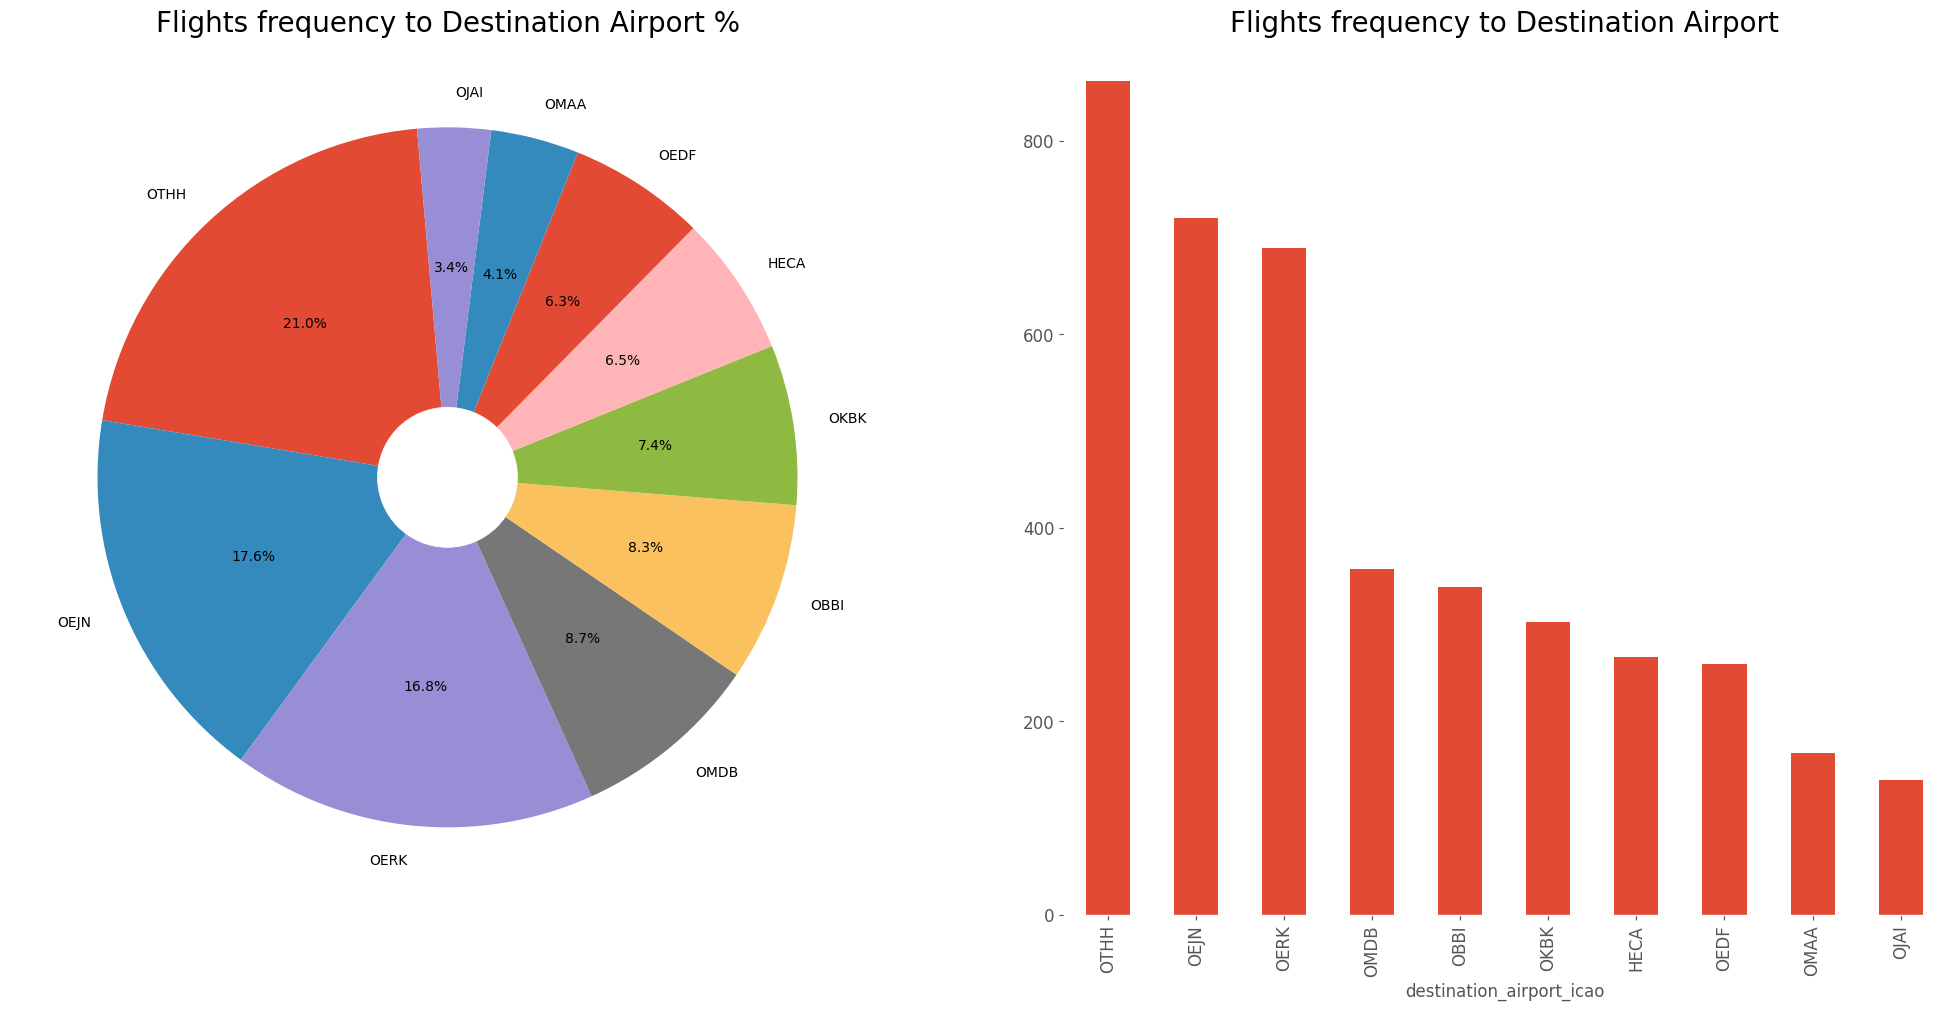

In [87]:
fig = plt.figure(figsize=[25, 25])
ax = fig.add_subplot(221)
ax.pie(buzAir, labeldistance=1.1, labels=buzAir.index, startangle=95, autopct='%1.1f%%', shadow=False)
ax.set_title("Flights frequency to Destination Airport %", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.set_title("Flights frequency to Destination Airport", fontsize=20);
ax2.set_facecolor('white')
buzAir.plot(kind='bar', ax=ax2,  legend=False, fontsize=12)
plt.show()

In [88]:
buzMonth = dd.groupby(['days'])['days'].count().sort_values(ascending=False)
buzMonth

days
Monday       4854
Tuesday      2140
Wednesday    1353
Thursday     1304
Friday        918
Saturday      751
Sunday        695
Name: days, dtype: int64

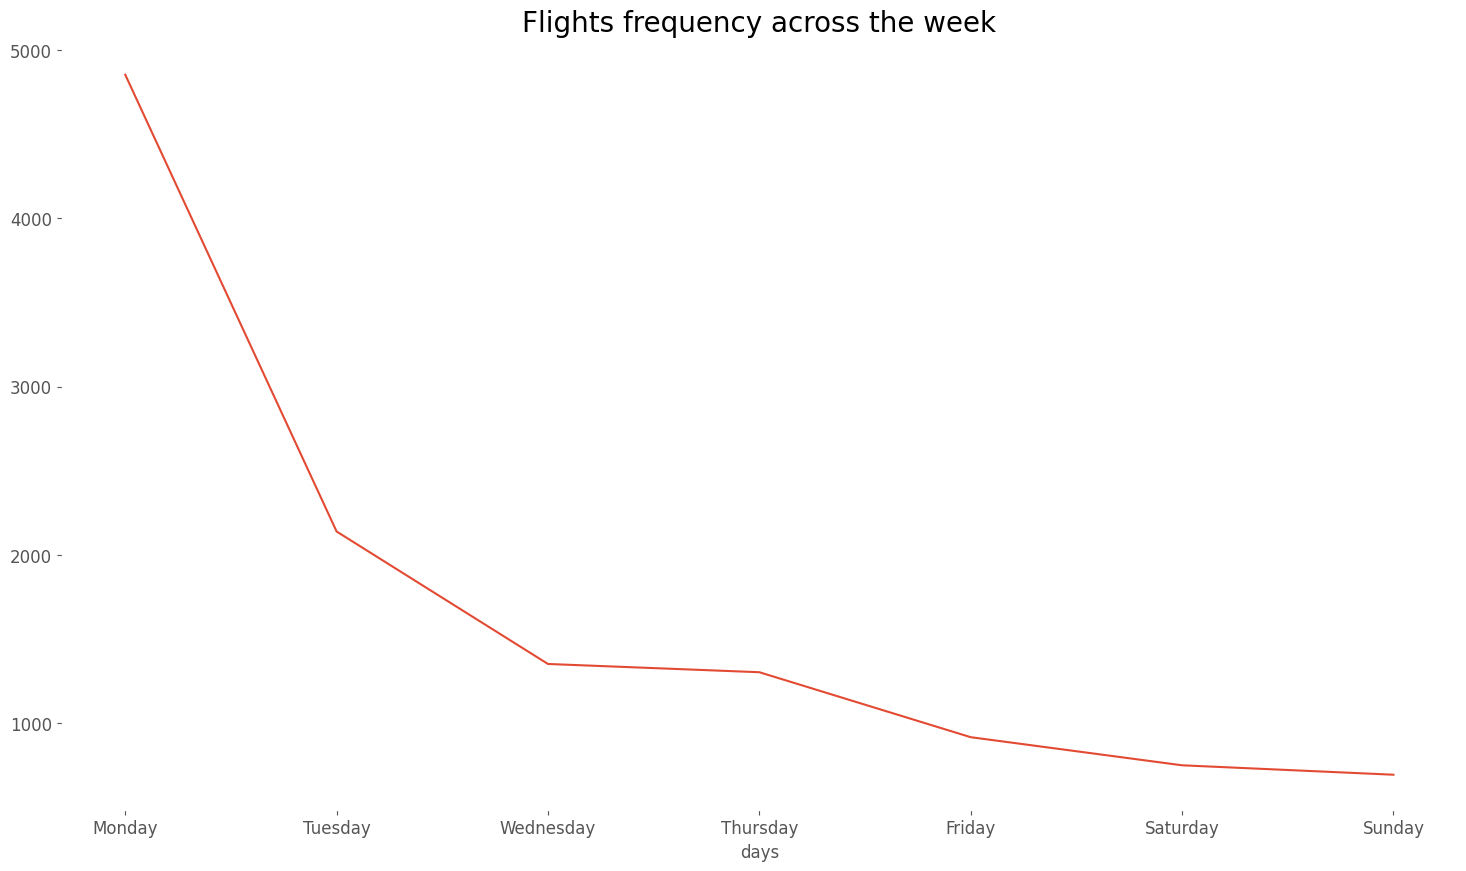

In [89]:
fig = plt.figure(figsize=[18, 10])
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.set_title("Flights frequency across the week", fontsize=20);
buzMonth.plot(ax=ax,  legend=False, fontsize=12)
plt.show()

In [91]:
oriair = dd.groupby(['origin_airport_icao'])['origin_airport_icao'].count().sort_values(ascending=False).head(10)
oriair 

origin_airport_icao
OTHH    969
OEJN    773
OERK    740
OMDB    490
OBBI    436
HECA    297
OEDF    269
OKBK    243
OEMA    196
OMAA    162
Name: origin_airport_icao, dtype: int64

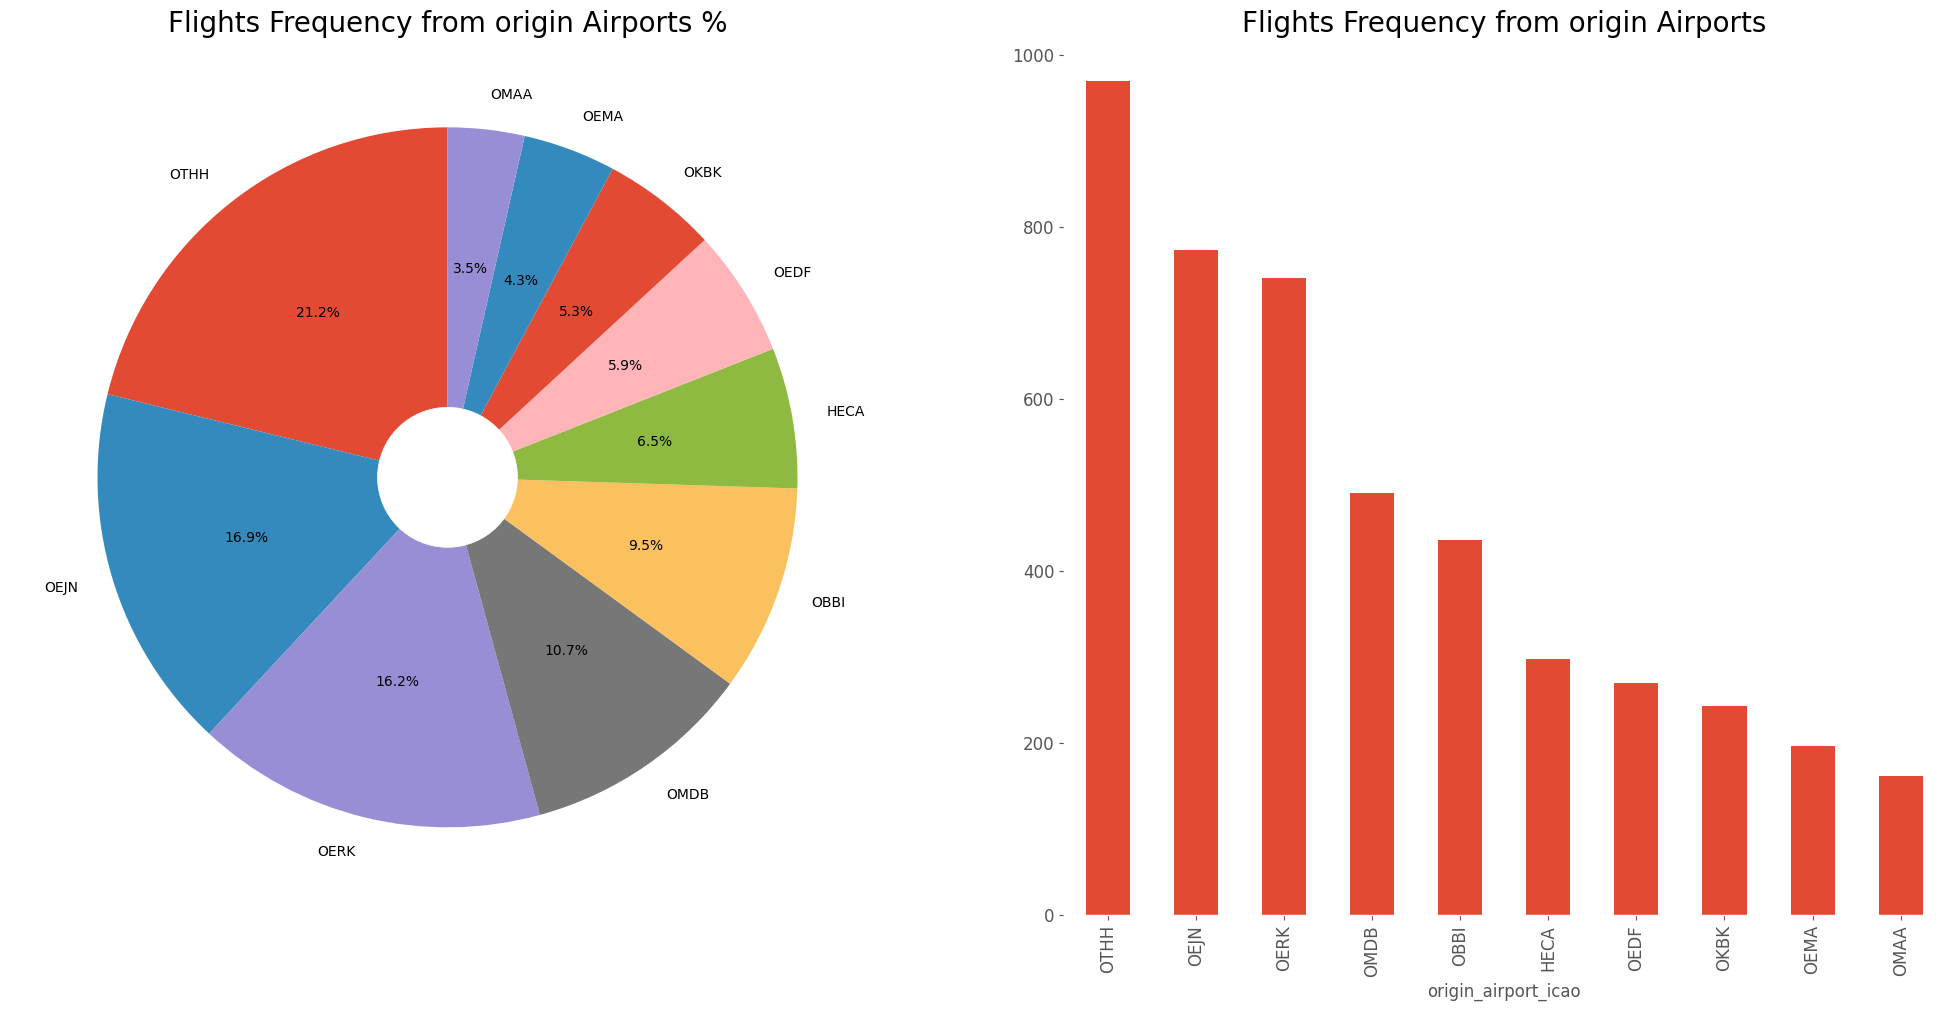

In [92]:
fig = plt.figure(figsize=[25, 25])
ax = fig.add_subplot(221)
ax.pie(oriair, labeldistance=1.1, labels=oriair.index, startangle=90, autopct='%1.1f%%', shadow=False)
ax.set_title("Flights Frequency from origin Airports %", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.set_title("Flights Frequency from origin Airports", fontsize=20);
ax2.set_facecolor('white')
oriair.plot(kind='bar', ax=ax2,  legend=False, fontsize=12)
plt.show()

In [17]:
flights['estimated_arrival_time_local'] = flights['estimated_arrival_time_local'].astype('datetime64[ns]')
flights['estimated_arrival_time_utc'] = flights['estimated_arrival_time_utc'].astype('datetime64[ns]')
flights['scheduled_arrival_time_local'] = flights['scheduled_arrival_time_local'].astype('datetime64[ns]')
flights['scheduled_arrival_time_utc'] = flights['scheduled_arrival_time_utc'].astype('datetime64[ns]')
flights['scheduled_departure_time_local'] = flights['scheduled_departure_time_local'].astype('datetime64[ns]')
flights['scheduled_departure_time_utc'] = flights['scheduled_departure_time_utc'].astype('datetime64[ns]')


In [38]:
flights['arrival_status'] = flights['estimated_arrival_time_local'] - flights['scheduled_arrival_time_local']

In [44]:
flights["arrival_status"] = flights['estimated_arrival_time_local'].sub(flights['scheduled_arrival_time_local']).dt.total_seconds().div(60)

In [46]:
flights['arrival_status_txt'] = np.where(flights['arrival_status'] <= 0,'OnTime','Late')


In [31]:
ds = flights.drop_duplicates(subset=['callsign','tail_number','on_ground'])


In [19]:
ds = ds[ds['on_ground'] != 'True']

In [19]:
p = ds[ds.duplicated(subset=['callsign','on_ground'], keep=False)].sort_values(by=['tail_number'])

In [50]:

arrStatus = dd.groupby('arrival_status_txt')['arrival_status_txt'].count()
print(arrStatus)

arrival_status_txt
Late      9598
OnTime    2407
Name: arrival_status_txt, dtype: int64


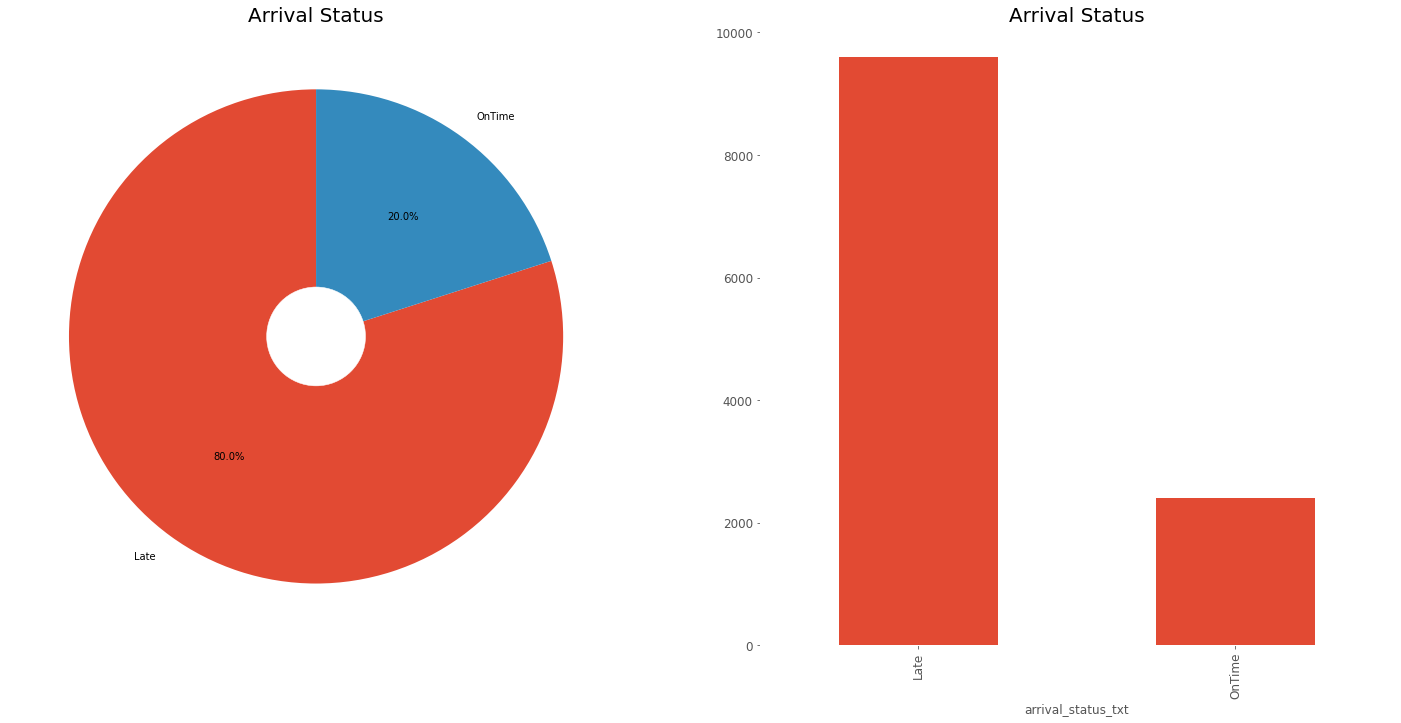

In [100]:
fig = plt.figure(figsize=[25, 25])
ax = fig.add_subplot(221)
ax.pie(arrStatus, labeldistance=1.1, labels=arrStatus.index, startangle=90, autopct='%1.1f%%', shadow=False)
ax.set_title("Arrival Status", fontsize=20);
plt.gcf().gca().add_artist(plt.Circle( (0,0), 0.2, color='white'))

ax2 = fig.add_subplot(222)
ax2.set_title("Arrival Status", fontsize=20);
ax2.set_facecolor('white')
arrStatus.plot(kind='bar', ax=ax2,  legend=False, fontsize=12)
plt.show()

In [103]:
depCarrier = dd.loc[dd['arrival_status_txt'] == 'Late'].groupby(['callsign','arrival_status_txt'])['arrival_status_txt'].count().unstack('arrival_status_txt')
depCarrier

arrival_status_txt,Late
callsign,
,2
.A9C-AI,1
.HZ-AQC,1
0000,1
1TRPQ81,1
...,...
ZAM44,1
ZAV4131,2
ZAV4133,1


In [ ]:
air_port = pd.read_csv(r'airport-codes.csv')


In [24]:
air_portSA = air_port[air_port['iso_country'] == 'SA']

In [32]:
air_portsa = air_portSA[(air_portSA['gps_code'].isin(flights.destination_airport_icao ))]
air_portinter = air_port[(air_port['gps_code'].isin(ds.destination_airport_icao))|(ds['origin_airport_icao'].isin(air_port.gps_code))]

In [75]:
air_portinter = air_port[(air_port['gps_code'].isin(ds.destination_airport_icao))|(ds['origin_airport_icao'].isin(air_port.gps_code))]

In [78]:
air_portsa['longitude'] = air_portsa['coordinates'].apply(lambda x :x.split(',')[0]).astype(float)
air_portsa['latitude'] = air_portsa['coordinates'].apply(lambda x :x.split(',')[1]).astype(float)
air_portinter['longitude'] = air_portinter['coordinates'].apply(lambda x :x.split(',')[0]).astype(float)
air_portinter['latitude'] = air_portinter['coordinates'].apply(lambda x :x.split(',')[1]).astype(float)

In [79]:
air_port['longitude'] = air_port['coordinates'].apply(lambda x :x.split(',')[0]).astype(float)
air_port['latitude'] = air_port['coordinates'].apply(lambda x :x.split(',')[1]).astype(float)

In [36]:
saflights = ds[(ds['destination_airport_icao'].isin(air_portsa.gps_code))&(ds['origin_airport_icao'].isin(air_portsa.gps_code))]

In [50]:
ds = ds.dropna(subset=['destination_airport_icao','origin_airport_icao'])

In [76]:
ds = ds[ds['origin_airport_icao'].isin(air_portinter.gps_code)]

In [37]:
Ap = air_portsa['gps_code']

In [39]:
saflights = saflights.dropna(subset=['origin_airport_icao','destination_airport_icao'])

In [46]:
edges = ds[['origin_airport_icao', 'destination_airport_icao']].dropna().values
edges

array([['OEJN', 'OPIS'],
       ['VTBS', 'OEJN'],
       ['OEJN', 'OPLA'],
       ...,
       ['LFPG', 'OTHH'],
       ['OEDF', 'OEJN'],
       ['HAAB', 'OEJN']], dtype=object)

In [ ]:
gx = nx.from_edgelist(edges)
len(g.nodes()), len(g.edges())


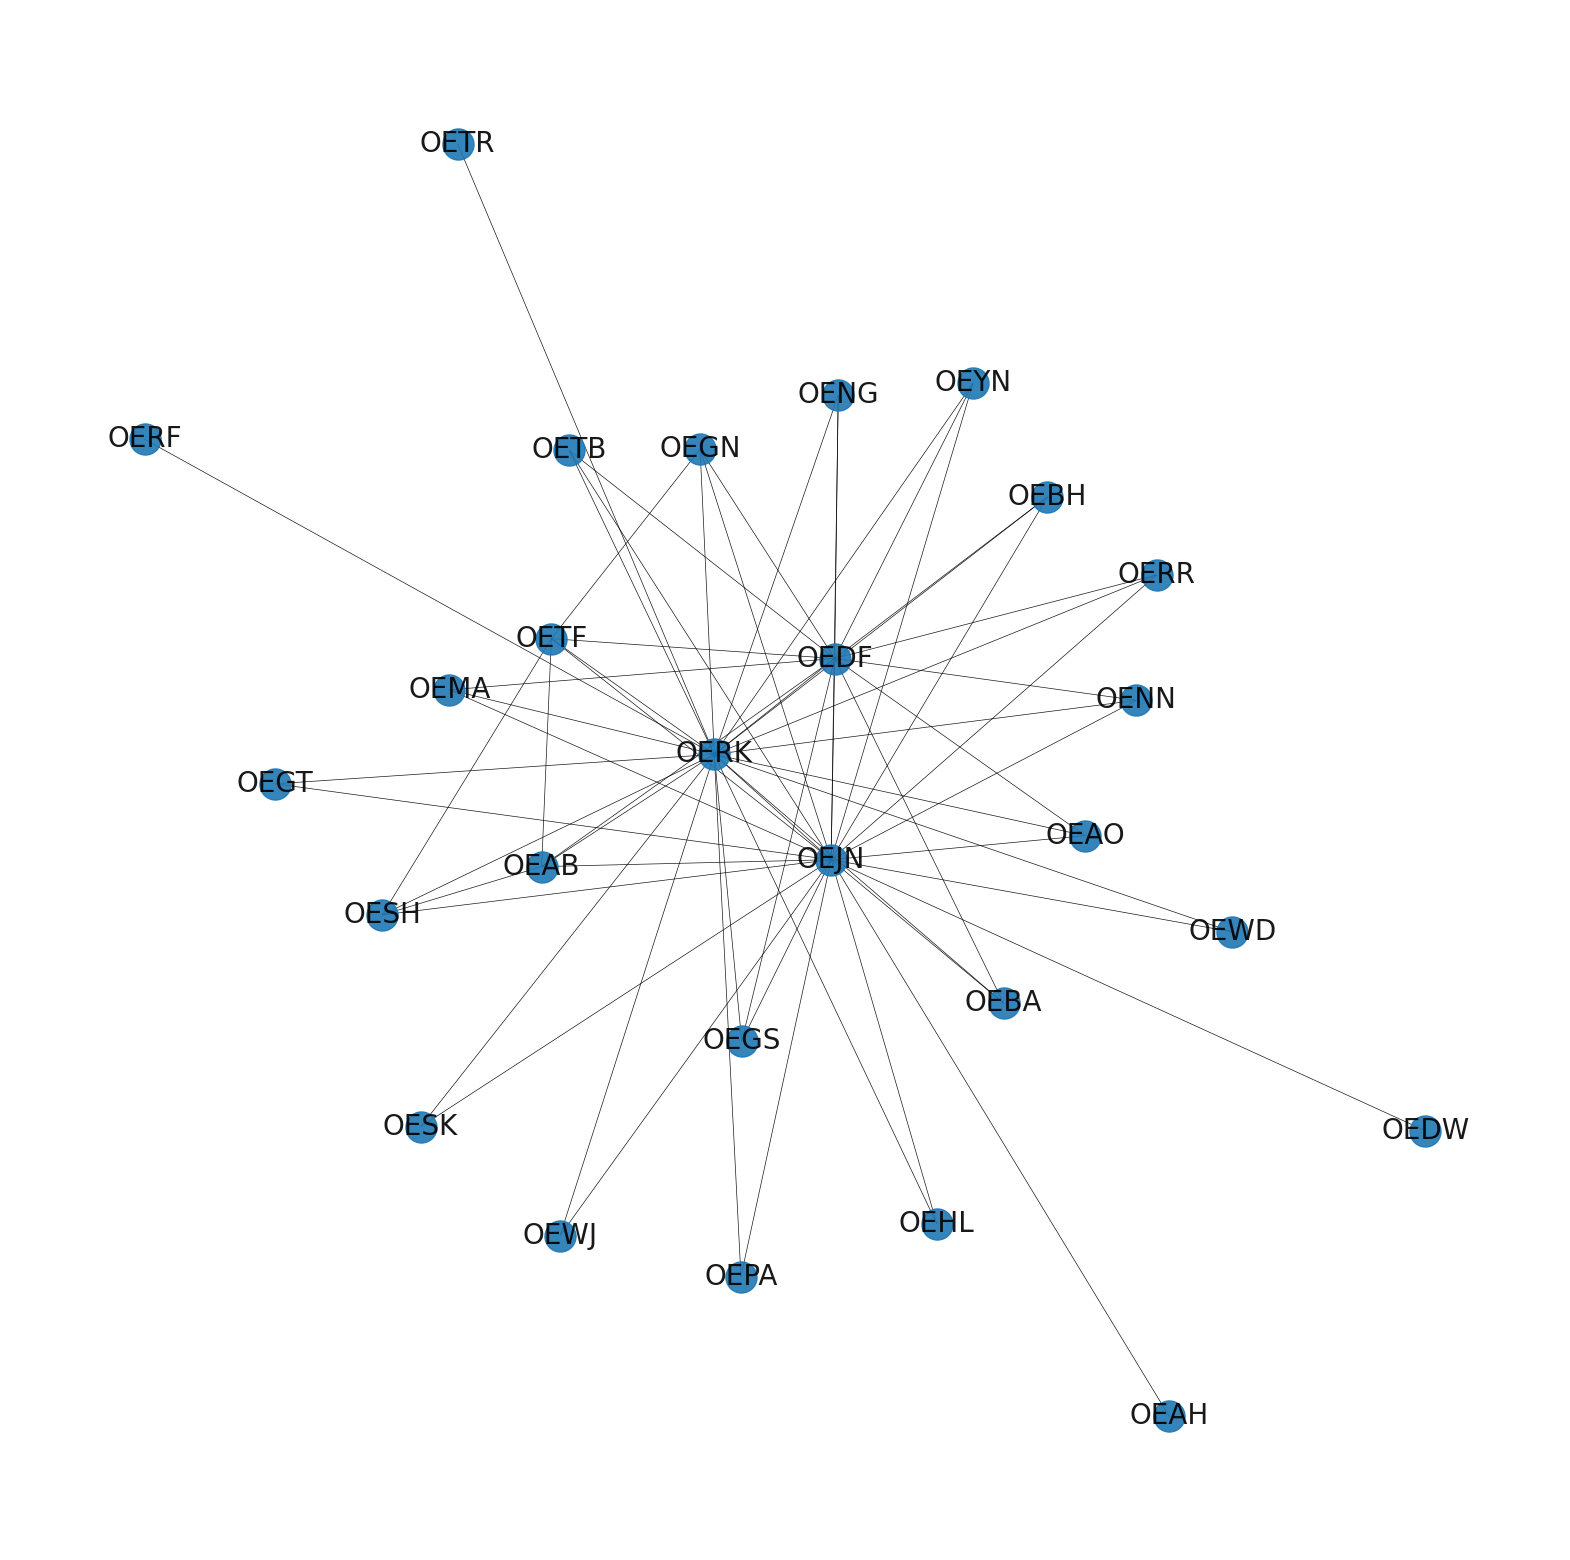

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
nx.draw_networkx(g, ax=ax, node_size=500,
                 font_size=20, alpha=.9,
                 width=.5)
ax.set_axis_off()

In [90]:
sg = (g.subgraph(c) for c in nx.connected_components(g))
sg = list(sg)[0]


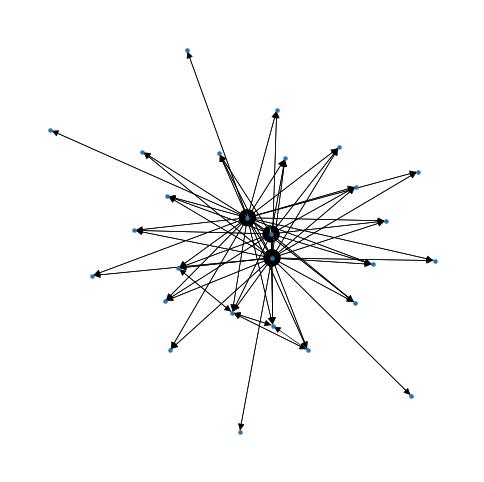

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(graph , ax=ax, with_labels=False,
                 node_size=5, width=.5)
ax.set_axis_off()

In [52]:
pos = {airport: (v['longitude'], v['latitude'])
       for airport, v in
       air_portsa.to_dict('index').items()}

In [97]:
deg = nx.degree(graph )
sizes = [5 * deg[iata] for iata in graph.nodes]

In [54]:
air_portsa = air_portsa.dropna(subset=['gps_code','elevation_ft'])

In [114]:
air_portsa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27 entries, 38851 to 50756
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         27 non-null     object 
 1   type          27 non-null     object 
 2   name          27 non-null     object 
 3   elevation_ft  27 non-null     float64
 4   continent     27 non-null     object 
 5   iso_country   27 non-null     object 
 6   iso_region    27 non-null     object 
 7   municipality  20 non-null     object 
 8   gps_code      27 non-null     object 
 9   iata_code     26 non-null     object 
 10  local_code    0 non-null      object 
 11  coordinates   27 non-null     object 
 12  latitude      27 non-null     float64
 13  longitude     27 non-null     float64
dtypes: float64(3), object(11)
memory usage: 4.2+ KB


In [100]:
def advanced_visualization (airport_df, routes_df):
	if (airport_df is None) or (routes_df is None):
		print ("Data cannot be retrieved and read")
	else:

		us_airport_ix = airport_df.index.values
		#extract routes that flyies from AND to USA
		routes_df =  pd.DataFrame(routes_df.groupby(['origin_airport_icao', 'destination_airport_icao']).size().reset_index(name='counts'))
		# to find number of flights in and out of an airport
		# it is similar to find number of rows in which each airport occur in either one of the 2 columns
		counts = routes_df['destination_airport_icao'].append(routes_df.loc[routes_df['origin_airport_icao'] != routes_df['destination_airport_icao'], 'destination_airport_icao']).value_counts()
		# create a data frame of position based on names in count
		counts = pd.DataFrame({'gps_code': counts.index, 'total_flight': counts})
		pos_data = counts.merge(airport_df, on = 'gps_code')

		# Create graph
		graph = nx.from_pandas_edgelist(routes_df, source = 'origin_airport_icao', target = 'destination_airport_icao',
		                        edge_attr = 'counts',create_using = nx.DiGraph())

		# Set up base map
		plt.figure(figsize=(15,20))
		m = Basemap(
		        projection='merc',
        		llcrnrlon=20,
        		urcrnrlon=70,
        		llcrnrlat=10,
        		urcrnrlat=40,
		        lat_ts=0,
		        resolution='l',
		        suppress_ticks=True)

		# import long lat as m attribute
		mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
		pos = {}
		for count, elem in enumerate (pos_data['gps_code']):
		    pos[elem] = (mx[count], my[count])

		# draw nodes and edges and overly on basemap
		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 20],
		                       node_color = 'r', alpha = 0.8,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 20])

		nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
		                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 20})

		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 20],
		                       node_color = 'b', alpha = 0.6,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 20])

		nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'black', width = 2, 
		                       alpha= 0.20, arrows = False)

		m.drawcountries(linewidth = 1)
		m.drawstates(linewidth = 0.2)
		m.drawcoastlines(linewidth=1)
		m.fillcontinents(alpha = 0.3)
		line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
		line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
		line3 = mlines.Line2D(range(1), range(1), color="black", marker='',markerfacecolor="black")
		plt.legend((line1, line2, line3), ('Large Airport > 20 routes', 'Smaller airports', 'routes'),
		           loc=4, fontsize = 'xx-large')
		plt.title("Network graph of flight routes in the KSA", fontsize = 30)
		#m.bluemarble()
		plt.tight_layout()
		plt.show()
		print ("successful visualization")
		return 0

In [80]:
def advanced_visualization_inter (airport_df, routes_df):
	if (airport_df is None) or (routes_df is None):
		print ("Data cannot be retrieved and read")
	else:

		us_airport_ix = airport_df.index.values
		#extract routes that flyies from AND to USA
		routes_df =  pd.DataFrame(routes_df.groupby(['origin_airport_icao', 'destination_airport_icao']).size().reset_index(name='counts'))
		# to find number of flights in and out of an airport
		# it is similar to find number of rows in which each airport occur in either one of the 2 columns
		counts = routes_df['destination_airport_icao'].append(routes_df.loc[routes_df['origin_airport_icao'] != routes_df['destination_airport_icao'], 'destination_airport_icao']).value_counts()
		# create a data frame of position based on names in count
		counts = pd.DataFrame({'gps_code': counts.index, 'total_flight': counts})
		pos_data = counts.merge(airport_df, on = 'gps_code')

		# Create graph
		graph = nx.from_pandas_edgelist(routes_df, source = 'origin_airport_icao', target = 'destination_airport_icao',
		                        edge_attr = 'counts',create_using = nx.DiGraph())

		# Set up base map
		plt.figure(figsize=(15,20))
		m = Basemap(
		        projection='merc',
            	llcrnrlat=-90,
				 urcrnrlat=90,
            	llcrnrlon=-180,
				urcrnrlon=180,
		        lat_ts=0,
		        resolution='l',
		        suppress_ticks=True)

		# import long lat as m attribute
		mx, my = m(pos_data['longitude'].values, pos_data['latitude'].values)
		pos = {}
		for count, elem in enumerate (pos_data['gps_code']):
		    pos[elem] = (mx[count], my[count])

		# draw nodes and edges and overly on basemap
		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] >= 20],
		                       node_color = 'r', alpha = 0.8,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] >= 20])

		nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
		                        labels = {x:x for x in graph.nodes() if counts['total_flight'][x] >= 20})

		nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = [x for x in graph.nodes() if counts['total_flight'][x] < 20],
		                       node_color = 'b', alpha = 0.6,
		                       node_size = [counts['total_flight'][x]*4  for x in graph.nodes() if counts['total_flight'][x] < 20])

		nx.draw_networkx_edges(G = graph, pos = pos, edge_color = 'black', width = 2, 
		                       alpha= 0.20, arrows = False)

		m.drawcountries(linewidth = 1)
		m.drawstates(linewidth = 0.2)
		m.drawcoastlines(linewidth=1)
		m.fillcontinents(alpha = 0.3)
		line1 = mlines.Line2D(range(1), range(1), color="white", marker='o', markerfacecolor="red")
		line2 = mlines.Line2D(range(1), range(1), color="white", marker='o',markerfacecolor="blue")
		line3 = mlines.Line2D(range(1), range(1), color="black", marker='',markerfacecolor="black")
		plt.legend((line1, line2, line3), ('Large Airport > 20 routes', 'Smaller airports', 'routes'),
		           loc=4, fontsize = 'xx-large')
		plt.title("Network graph of flight routes in the KSA", fontsize = 30)
		#m.bluemarble()
		plt.tight_layout()
		plt.show()
		print ("successful visualization")
		return 0

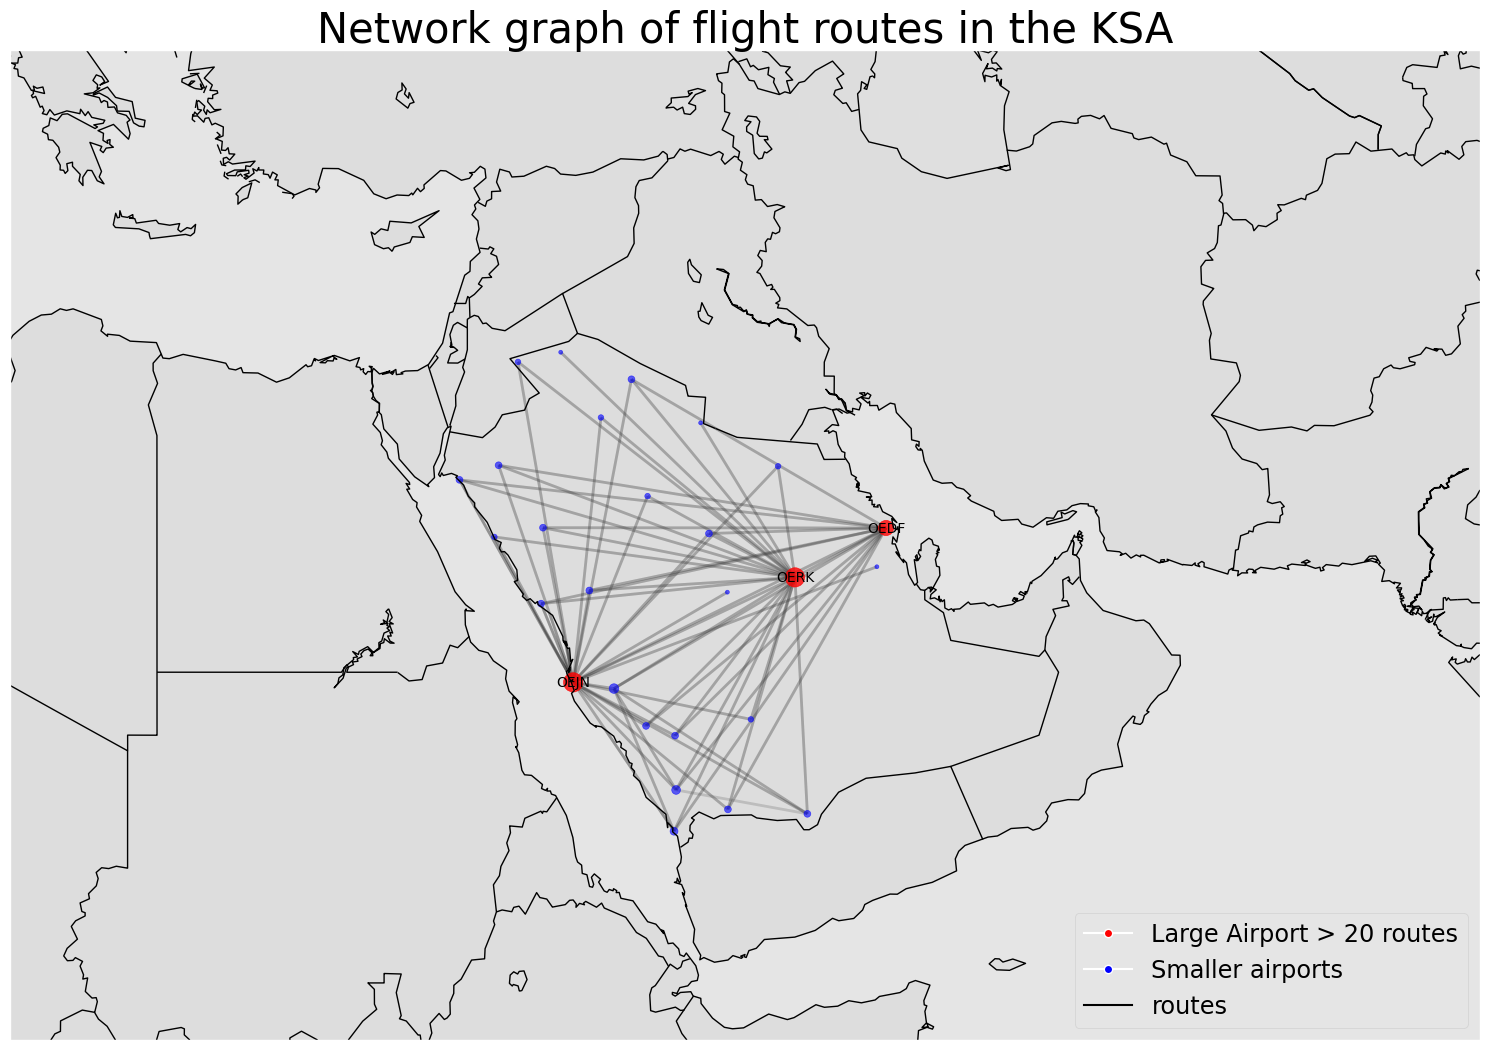

successful visualization


0

In [101]:
advanced_visualization(air_portsa,saflights)